In [52]:
# Dependencies 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import linregress
import scipy.stats as st 
from api_keys import api_key

In [2]:
# Try opening the CSV file with different encodings

nfl_teams = pd.read_csv("archive/nfl_teams.csv")
scores_data = pd.read_csv("archive/spreadspoke_scores.csv")


encodings_to_try = ["utf-8", "latin-1", "ISO-8859-1"]

for encoding in encodings_to_try:
    try:
        with open("archive/nfl_stadiums.csv", encoding=encoding) as file:
            stadiums = pd.read_csv(file)
        break  # Stop trying encodings if successful
    except UnicodeDecodeError:
        continue  # Try the next encoding if unsuccessful

# If none of the encodings work, you can specify 'errors' to handle decoding errors
if not "stadiums" in locals():
    with open("archive/nfl_stadiums.csv", encoding="utf-8", errors="replace") as file:
        stadiums = pd.read_csv(file)



In [3]:
# only use data from 09/01/1979 to 02/12/2023
# Assuming "schedule_date" is a string column, convert it to a datetime object
scores_data['schedule_date'] = pd.to_datetime(scores_data['schedule_date'])

# Define the date range
start_date = '1979-09-01'
end_date = '2023-02-12'

# Create a mask for the date range
date_mask = (scores_data['schedule_date'] >= start_date) & (scores_data['schedule_date'] <= end_date)

# Apply the mask to filter the DataFrame
filtered_scores_data = scores_data[date_mask]

# Now, filtered_scores_data contains the games within the specified date range
filtered_scores_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30,Houlihan's Stadium,False,79.0,9.0,87.0,NaN
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31,Soldier Field,False,78.0,11.0,68.0,NaN
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37,Arrowhead Stadium,False,76.0,8.0,71.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain


In [4]:
# create a new column to calculate the total scores of the game and compare to the over/under line
filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']

filtered_scores_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11015 entries, 2501 to 13515
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   schedule_date        11015 non-null  datetime64[ns]
 1   schedule_season      11015 non-null  int64         
 2   schedule_week        11015 non-null  object        
 3   schedule_playoff     11015 non-null  bool          
 4   team_home            11015 non-null  object        
 5   score_home           11015 non-null  float64       
 6   score_away           11015 non-null  float64       
 7   team_away            11015 non-null  object        
 8   team_favorite_id     11015 non-null  object        
 9   spread_favorite      11015 non-null  float64       
 10  over_under_line      11015 non-null  object        
 11  stadium              11015 non-null  object        
 12  stadium_neutral      11015 non-null  bool          
 13  weather_temperature  10055 non-nu

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3288269676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['total_score'] = filtered_scores_data['score_home'] + filtered_scores_data['score_away']


In [5]:
# Convert the over_under_line to a numerical data type
filtered_scores_data.loc[:,'over_under_line'] = pd.to_numeric(filtered_scores_data['over_under_line'], errors='coerce')
# create a new column calculating the accuracy of the over_under_line to the total_score
filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)
filtered_scores_data

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3086248996.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = pd.to_numeric(filtered_scores_data['total_score'] / filtered_scores_data['over_under_line'] * 100)
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3086248996.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['accuracy'] = round((filtered_scores_data['accuracy']), 2)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30.0,Houlihan's Stadium,False,79.0,9.0,87.0,NaN,47.0,156.67
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39.0,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN,16.0,41.03
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68.0,NaN,9.0,29.03
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN,10.0,31.75
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,NaN,14.0,37.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52


In [36]:
# Filter data Sets
# Create a new DataFrame without NaN values in the 'accuracy' column
final_scores_data = filtered_scores_data.dropna(subset=['over_under_line'])
# Create a DataFrame for regular season games
reg_szn = filtered_scores_data.loc[filtered_scores_data["schedule_playoff"] == False]

# Define the date ranges
date_range_1 = ('2013-09-05', '2023-02-12')
date_range_2 = ('2003-09-04', '2013-02-03')
date_range_3 = ('1993-09-05', '2003-01-26')

# Create masks for each date range
mask_1 = (filtered_scores_data['schedule_date'] >= date_range_1[0]) & (filtered_scores_data['schedule_date'] <= date_range_1[1])
mask_2 = (filtered_scores_data['schedule_date'] >= date_range_2[0]) & (filtered_scores_data['schedule_date'] <= date_range_2[1])
mask_3 = (filtered_scores_data['schedule_date'] >= date_range_3[0]) & (filtered_scores_data['schedule_date'] <= date_range_3[1])

# Create data sets for each date range
decade1 = filtered_scores_data[mask_1]
decade2 = filtered_scores_data[mask_2]
decade3 = filtered_scores_data[mask_3]

final_scores_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy,temp_feel
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30.0,Houlihan's Stadium,False,79.0,9.0,87.0,NaN,47.0,156.67,hot
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39.0,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN,16.0,41.03,warm
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68.0,NaN,9.0,29.03,hot
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN,10.0,31.75,warm
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,NaN,14.0,37.84,hot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29,very cold
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67,cold
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58,very cold
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52,cold


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2555001021.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['over_under_line'] = pd.to_numeric(final_scores_data['over_under_line'], errors='coerce')
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2555001021.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['total_score'] = pd.to_numeric(final_scores_data['total_score'], errors='coerce')


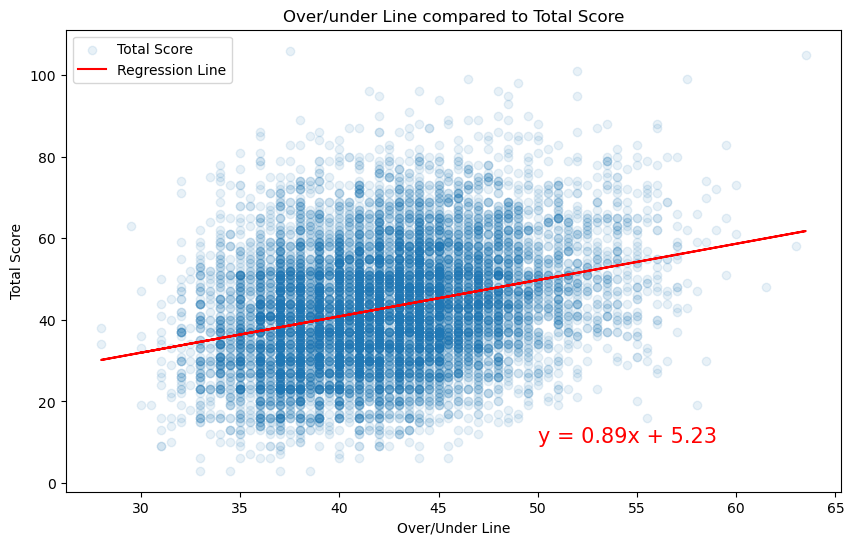

The correlation between Total Score and the over/under line is 0.3


<Figure size 640x480 with 0 Axes>

In [53]:
# Plot the data comparing the over_under_line to the total_score with regression line
def plot_linear_regression(x_values, y_values, ylabel, coordinates, title):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_values, y_values, alpha=0.1, label='Total Score')

    # Add the regression line to the plot
    plt.plot(x_values, regress_values, color='red', label='Regression Line')

    # Annotate the equation on the plot
    plt.annotate(line_eq, coordinates, fontsize=15, color="red")

    # Set the title and labels for the axes
    plt.xlabel('Over/Under Line')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

final_scores_data['over_under_line'] = pd.to_numeric(final_scores_data['over_under_line'], errors='coerce')
final_scores_data['total_score'] = pd.to_numeric(final_scores_data['total_score'], errors='coerce')

# Your x and y values

x_values = final_scores_data['over_under_line']
y_values = final_scores_data['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (50, 10), 'Over/under Line compared to Total Score')
plt.savefig('images/OUTSall.png')
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Total Score and the over/under line is {round(correlation[0],2)}")

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3888067955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade1['over_under_line'] = pd.to_numeric(decade1['over_under_line'], errors='coerce')
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3888067955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade1['total_score'] = pd.to_numeric(decade1['total_score'], errors='coerce')


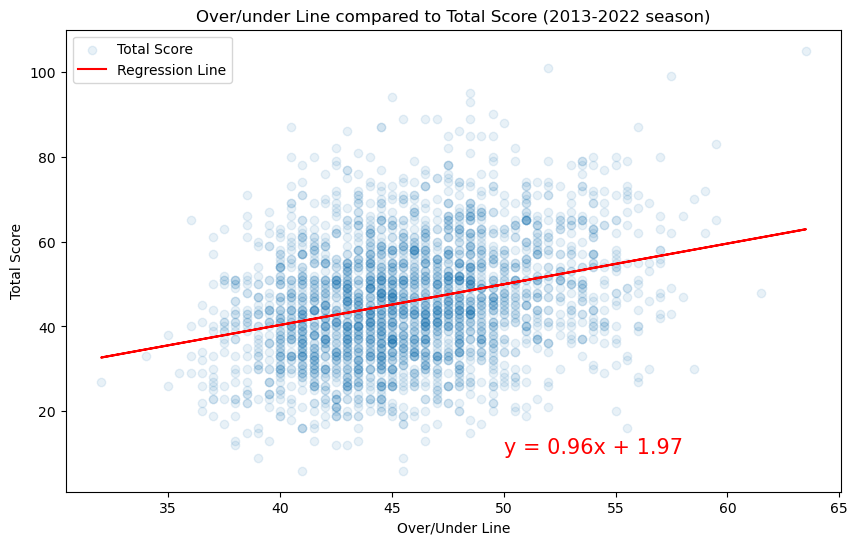

The correlation between Total Score and the over/under line for 2013 to 2022 is 0.3


<Figure size 640x480 with 0 Axes>

In [54]:
decade1['over_under_line'] = pd.to_numeric(decade1['over_under_line'], errors='coerce')
decade1['total_score'] = pd.to_numeric(decade1['total_score'], errors='coerce')

# Your x and y values

x_values = decade1['over_under_line']
y_values = decade1['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (50, 10), 'Over/under Line compared to Total Score (2013-2022 season)')
plt.savefig('images/OUTSD1.png')
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Total Score and the over/under line for 2013 to 2022 is {round(correlation[0],2)}")

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2772963077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade2['over_under_line'] = pd.to_numeric(decade2['over_under_line'], errors='coerce')
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2772963077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade2['total_score'] = pd.to_numeric(decade2['total_score'], errors='coerce')


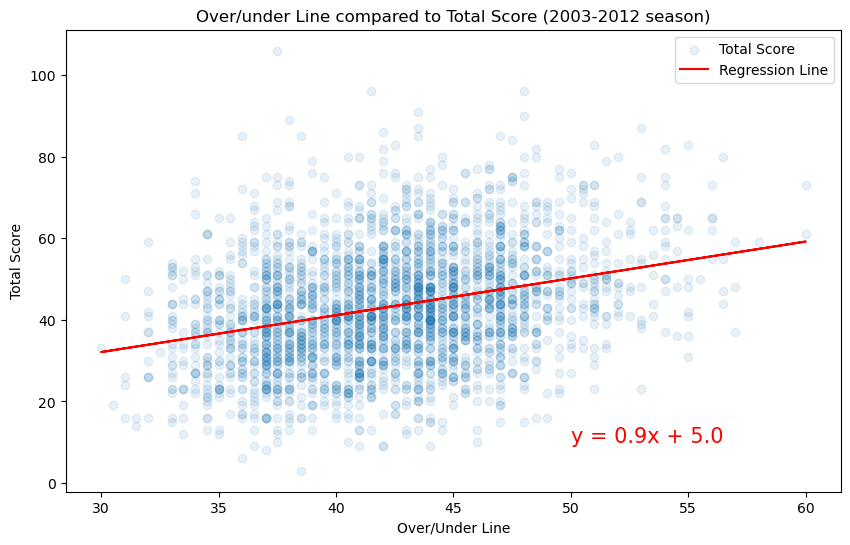

The correlation between Total Score and the over/under line for 2003 to 2012 is 0.31


<Figure size 640x480 with 0 Axes>

In [55]:
decade2['over_under_line'] = pd.to_numeric(decade2['over_under_line'], errors='coerce')
decade2['total_score'] = pd.to_numeric(decade2['total_score'], errors='coerce')

# Your x and y values

x_values = decade2['over_under_line']
y_values = decade2['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (50, 10), 'Over/under Line compared to Total Score (2003-2012 season)')
plt.savefig('images/OUTSD2.png')
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Total Score and the over/under line for 2003 to 2012 is {round(correlation[0],2)}")

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/1285843457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade3['over_under_line'] = pd.to_numeric(decade3['over_under_line'], errors='coerce')
/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/1285843457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  decade3['total_score'] = pd.to_numeric(decade3['total_score'], errors='coerce')


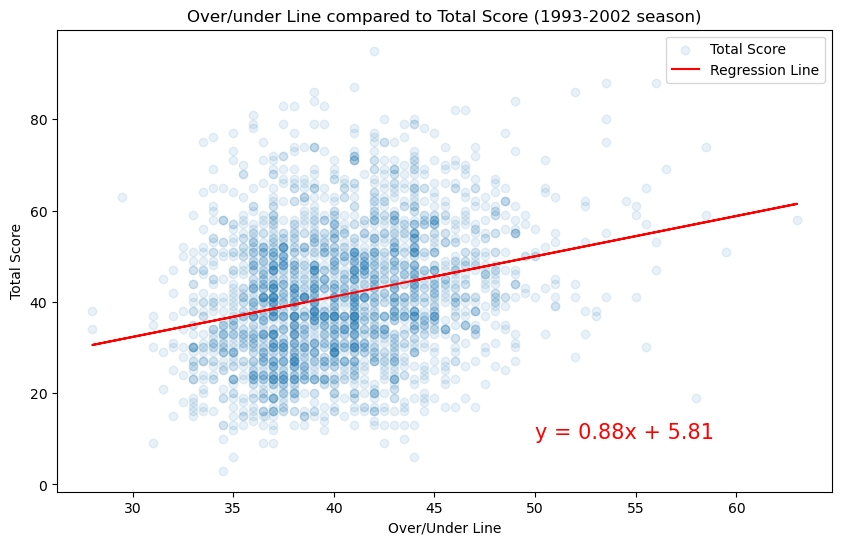

The correlation between Total Score and the over/under line for 1993 to 2002 is 0.26


<Figure size 640x480 with 0 Axes>

In [56]:
decade3['over_under_line'] = pd.to_numeric(decade3['over_under_line'], errors='coerce')
decade3['total_score'] = pd.to_numeric(decade3['total_score'], errors='coerce')

# Your x and y values

x_values = decade3['over_under_line']
y_values = decade3['total_score']

plot_linear_regression(x_values, y_values, 'Total Score', (50, 10), 'Over/under Line compared to Total Score (1993-2002 season)')
plt.savefig('images/OUTSD3.png')
correlation = st.pearsonr(x_values,y_values)
print(f"The correlation between Total Score and the over/under line for 1993 to 2002 is {round(correlation[0],2)}")

In [41]:
# Define the temperature bins and labels
temperature_bins = [0, 45, 55, 65, 75, 85, float('inf')]  # Temperature bins
temperature_labels = ["very cold", "cold", "cool", "warm", "hot", "very hot"]  # Category labels

# Create a new column 'temperature_category' based on the temperature bins
filtered_scores_data['temp_feel'] = pd.cut(filtered_scores_data['weather_temperature'], bins=temperature_bins, labels=temperature_labels)

# Now, 'filtered_scores_data' contains the new 'temperature_category' column
filtered_scores_data

/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2104305708.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores_data['temp_feel'] = pd.cut(filtered_scores_data['weather_temperature'], bins=temperature_bins, labels=temperature_labels)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy,temp_feel
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30.0,Houlihan's Stadium,False,79.0,9.0,87.0,NaN,47.0,156.67,hot
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39.0,Ralph Wilson Stadium,False,74.0,15.0,74.0,NaN,16.0,41.03,warm
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31.0,Soldier Field,False,78.0,11.0,68.0,NaN,9.0,29.03,hot
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,Mile High Stadium,False,69.0,6.0,38.0,NaN,10.0,31.75,warm
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37.0,Arrowhead Stadium,False,76.0,8.0,71.0,NaN,14.0,37.84,hot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,48.5,Highmark Stadium,False,32.0,4.0,100.0,snow,37.0,76.29,very cold
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,46.5,Levi's Stadium,False,55.0,19.0,47.0,NaN,31.0,66.67,cold
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,48.0,GEHA Field at Arrowhead Stadium,False,22.0,13.0,55.0,NaN,43.0,89.58,very cold
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,45.5,Lincoln Financial Field,False,52.0,14.0,48.0,rain,38.0,83.52,cold


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3644317062.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['temp_feel_numeric'] = final_scores_data['temp_feel'].map(temperature_category_mapping)


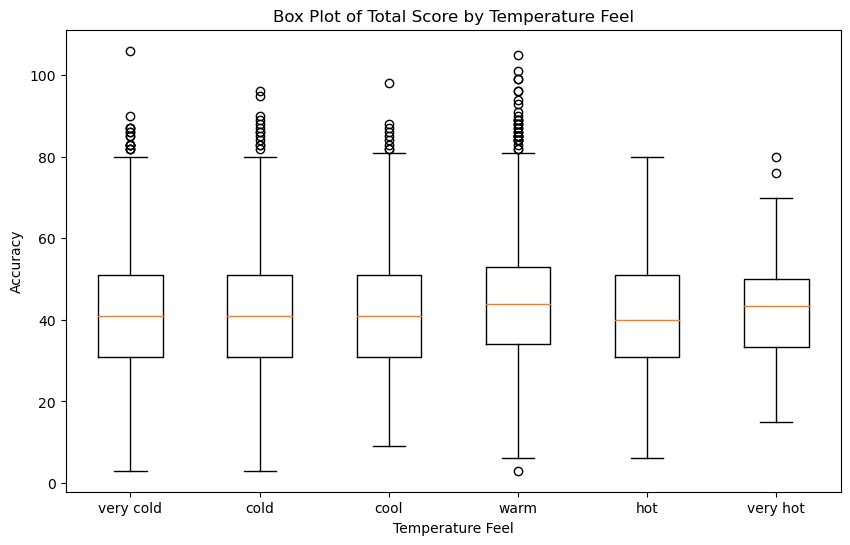

<Figure size 640x480 with 0 Axes>

In [42]:
# Create a new DataFrame without NaN values in the 'accuracy' column
final_scores_data = filtered_scores_data.dropna(subset=['accuracy'])

# Create a mapping for temperature categories to numeric values
temperature_category_mapping = {
    "very hot": 5,
    "hot": 4,
    "warm": 3,
    "cool": 2,
    "cold": 1,
    "very cold": 0
}

# Map the "temperature_category" to numeric values
final_scores_data['temp_feel_numeric'] = final_scores_data['temp_feel'].map(temperature_category_mapping)

# Create a box plot
plt.figure(figsize=(10, 6))
boxplot_data = []
category_labels = []

for category, group in final_scores_data.groupby('temp_feel'):
    boxplot_data.append(group['total_score'])
    category_labels.append(category)

plt.boxplot(boxplot_data, labels=category_labels)

# Set labels and title
plt.xlabel('Temperature Feel')
plt.ylabel('Accuracy')
plt.title('Box Plot of Total Score by Temperature Feel')

# Show the plot
plt.show()
plt.savefig('images/TStemp.png')


In [58]:
# Perform the ANOVA test on 'total_score' by 'temp_feel' categories
anova_result = st.f_oneway(
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "very cold"],
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "cold"],
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "cool"],
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "warm"],
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "hot"],
    final_scores_data['total_score'][final_scores_data['temp_feel'] == "very hot"]
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 14.188809963768884
ANOVA p-value: 7.30911512605091e-14
The differences are statistically significant (reject the null hypothesis).


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/2915162168.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['temp_feel_numeric'] = final_scores_data['temp_feel'].map(temperature_category_mapping)


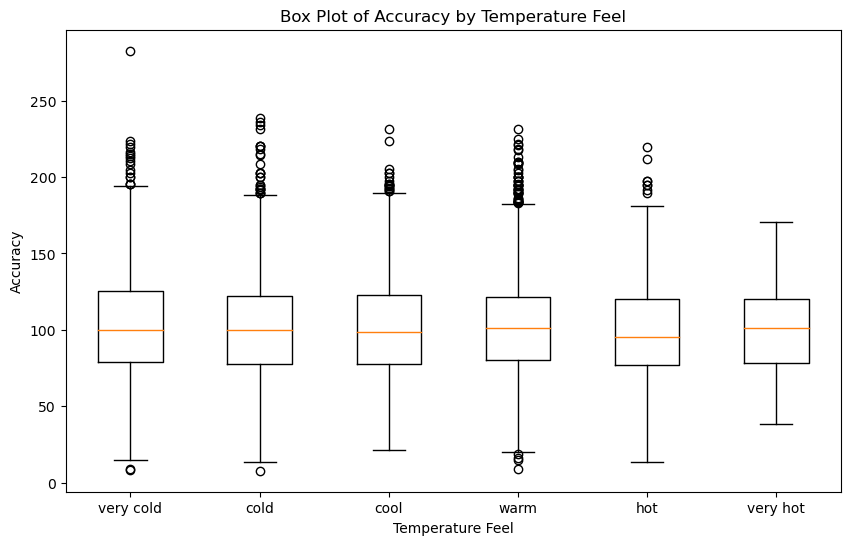

<Figure size 640x480 with 0 Axes>

In [43]:
# Create a mapping for temperature categories to numeric values
temperature_category_mapping = {
    "very hot": 5,
    "hot": 4,
    "warm": 3,
    "cool": 2,
    "cold": 1,
    "very cold": 0
}

# Map the "temperature_category" to numeric values
final_scores_data['temp_feel_numeric'] = final_scores_data['temp_feel'].map(temperature_category_mapping)

# Create a box plot
plt.figure(figsize=(10, 6))
boxplot_data = []
category_labels = []

for category, group in final_scores_data.groupby('temp_feel'):
    boxplot_data.append(group['accuracy'])
    category_labels.append(category)

plt.boxplot(boxplot_data, labels=category_labels)

# Set labels and title
plt.xlabel('Temperature Feel')
plt.ylabel('Accuracy')
plt.title('Box Plot of Accuracy by Temperature Feel')

# Show the plot
plt.show()
plt.savefig('images/ACCtemp.png')


In [57]:
# Perform the ANOVA test on 'accuracy' by 'temp_feel' categories
anova_result = st.f_oneway(
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "very cold"],
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "cold"],
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "cool"],
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "warm"],
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "hot"],
    final_scores_data['accuracy'][final_scores_data['temp_feel'] == "very hot"]
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 1.9809639929533758
ANOVA p-value: 0.07807725102571389
The differences are not statistically significant (fail to reject the null hypothesis).


In [44]:
# Find the row with the highest total score in the whole dataset
highest_score_row = filtered_scores_data[filtered_scores_data['total_score'] == filtered_scores_data['total_score'].max()]

highest_score_row

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy,temp_feel
8571,2004-11-28,2004,12,False,Cincinnati Bengals,58.0,48.0,Cleveland Browns,CIN,-6.0,37.5,Paul Brown Stadium,False,40.0,14.0,77.0,NaN,106.0,282.67,very cold


In [45]:
# Find the row(s) with the lowest total score in the whole dataset
lowest_score_row = filtered_scores_data[filtered_scores_data['total_score'] == filtered_scores_data['total_score'].min()]

lowest_score_row

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy,temp_feel
2723,1979-12-16,1979,16,False,Tampa Bay Buccaneers,3.0,0.0,Kansas City Chiefs,TB,-3.0,33.0,Houlihan's Stadium,False,67.0,8.0,92.0,NaN,3.0,9.09,warm
3279,1982-12-12,1982,14,False,New England Patriots,3.0,0.0,Miami Dolphins,MIA,-6.0,37.0,Foxboro Stadium,False,26.0,16.0,51.0,NaN,3.0,8.11,very cold
5790,1993-12-11,1993,15,False,Washington Redskins,0.0,3.0,New York Jets,NYJ,-3.0,34.5,RFK Memorial Stadium,False,43.0,20.0,70.0,NaN,3.0,8.70,very cold
9382,2007-11-26,2007,12,False,Pittsburgh Steelers,3.0,0.0,Miami Dolphins,PIT,-16.0,38.5,Heinz Field,False,46.0,7.0,88.0,NaN,3.0,7.79,cold


In [46]:
# Define the humidity bins and labels
humidity_bins = [0, 20, 40, 60, 80, float('inf')]  # Humidity bins
humidity_labels = ["very dry", "dry", "comfortable", "humid", "very humid"]  # Category labels

# Create a new column 'humidity_category' based on the humidity bins
final_scores_data['humid_feel'] = pd.cut(final_scores_data['weather_humidity'], bins=humidity_bins, labels=humidity_labels)

# Now, 'filtered_scores_data' contains the new 'humidity_category' column
final_scores_data


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/1601325149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['humid_feel'] = pd.cut(final_scores_data['weather_humidity'], bins=humidity_bins, labels=humidity_labels)


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,total_score,accuracy,temp_feel,temp_feel_numeric,humid_feel
2501,1979-09-01,1979,1,False,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,...,False,79.0,9.0,87.0,NaN,47.0,156.67,hot,4,very humid
2502,1979-09-02,1979,1,False,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,...,False,74.0,15.0,74.0,NaN,16.0,41.03,warm,3,humid
2503,1979-09-02,1979,1,False,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,...,False,78.0,11.0,68.0,NaN,9.0,29.03,hot,4,humid
2504,1979-09-02,1979,1,False,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,...,False,69.0,6.0,38.0,NaN,10.0,31.75,warm,3,dry
2505,1979-09-02,1979,1,False,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,...,False,76.0,8.0,71.0,NaN,14.0,37.84,hot,4,humid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13511,2023-01-22,2022,Division,True,Buffalo Bills,10.0,27.0,Cincinnati Bengals,BUF,-6.0,...,False,32.0,4.0,100.0,snow,37.0,76.29,very cold,0,very humid
13512,2023-01-22,2022,Division,True,San Francisco 49ers,19.0,12.0,Dallas Cowboys,SF,-3.5,...,False,55.0,19.0,47.0,NaN,31.0,66.67,cold,1,comfortable
13513,2023-01-29,2022,Conference,True,Kansas City Chiefs,23.0,20.0,Cincinnati Bengals,KC,-1.5,...,False,22.0,13.0,55.0,NaN,43.0,89.58,very cold,0,comfortable
13514,2023-01-29,2022,Conference,True,Philadelphia Eagles,31.0,7.0,San Francisco 49ers,PHI,-2.5,...,False,52.0,14.0,48.0,rain,38.0,83.52,cold,1,comfortable


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/655903730.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['humid_feel_numeric'] = final_scores_data['humid_feel'].map(humidity_category_mapping)


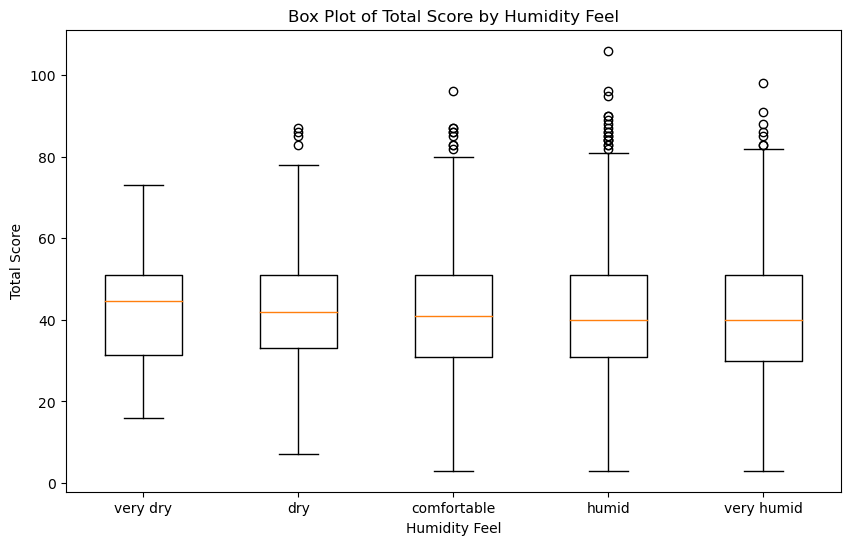

<Figure size 640x480 with 0 Axes>

In [47]:
# Create a mapping for humidity categories to numeric values
humidity_category_mapping = {
    "very humid": 4,
    "humid": 3,
    "comfortable": 2,
    "dry": 1,
    "very dry": 0
}

# Map the "humidity_category" to numeric values
final_scores_data['humid_feel_numeric'] = final_scores_data['humid_feel'].map(humidity_category_mapping)

# Create a box plot for humidity categories
plt.figure(figsize=(10, 6))
boxplot_data = []
category_labels = []

for category, group in final_scores_data.groupby('humid_feel'):
    boxplot_data.append(group['total_score'])
    category_labels.append(category)

plt.boxplot(boxplot_data, labels=category_labels)

# Set labels and title
plt.xlabel('Humidity Feel')
plt.ylabel('Total Score')
plt.title('Box Plot of Total Score by Humidity Feel')

# Show the plot
plt.show()
plt.savefig('images/TShum.png')


In [59]:
# Perform the ANOVA test on 'total_score' by 'humid_feel' categories
anova_result = st.f_oneway(
    final_scores_data['total_score'][final_scores_data['humid_feel'] == "very dry"],
    final_scores_data['total_score'][final_scores_data['humid_feel'] == "dry"],
    final_scores_data['total_score'][final_scores_data['humid_feel'] == "comfortable"],
    final_scores_data['total_score'][final_scores_data['humid_feel'] == "humid"],
    final_scores_data['total_score'][final_scores_data['humid_feel'] == "very humid"],
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 0.7396785305535963
ANOVA p-value: 0.5647957044620115
The differences are not statistically significant (fail to reject the null hypothesis).


/var/folders/7d/5c2gqmrn4mg4hc18ff5mjdw00000gn/T/ipykernel_4288/3987896771.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_scores_data['temp_feel_numeric'] = final_scores_data['humid_feel'].map(temperature_category_mapping)


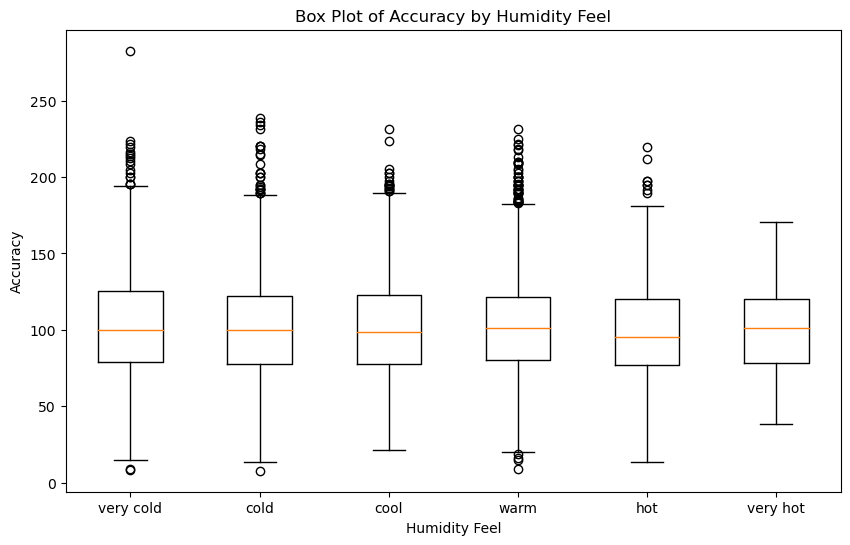

<Figure size 640x480 with 0 Axes>

In [63]:
# Create a mapping for temperature categories to numeric values
temperature_category_mapping = {
    "very hot": 5,
    "hot": 4,
    "warm": 3,
    "cool": 2,
    "cold": 1,
    "very cold": 0
}

# Map the "temperature_category" to numeric values
final_scores_data['temp_feel_numeric'] = final_scores_data['humid_feel'].map(temperature_category_mapping)

# Create a box plot
plt.figure(figsize=(10, 6))
boxplot_data = []
category_labels = []

for category, group in final_scores_data.groupby('temp_feel'):
    boxplot_data.append(group['accuracy'])
    category_labels.append(category)

plt.boxplot(boxplot_data, labels=category_labels)

# Set labels and title
plt.xlabel('Humidity Feel')
plt.ylabel('Accuracy')
plt.title('Box Plot of Accuracy by Humidity Feel')

# Show the plot
plt.show()
plt.savefig('images/ACChum.png')


In [64]:
# Perform the ANOVA test on 'accuracy' by 'humid_feel' categories
anova_result = st.f_oneway(
    final_scores_data['accuracy'][final_scores_data['humid_feel'] == "very dry"],
    final_scores_data['accuracy'][final_scores_data['humid_feel'] == "dry"],
    final_scores_data['accuracy'][final_scores_data['humid_feel'] == "comfortable"],
    final_scores_data['accuracy'][final_scores_data['humid_feel'] == "humid"],
    final_scores_data['accuracy'][final_scores_data['humid_feel'] == "very humid"],
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 0.12609372934590687
ANOVA p-value: 0.9730678682269946
The differences are not statistically significant (fail to reject the null hypothesis).


In [48]:
# Create a new DataFrame dropping rows with NaN values in the "weather_detail" column
weather_details = final_scores_data.dropna(subset=['weather_detail'])

# Display the updated DataFrame
weather_details.head()

# Get unique values in the "weather_detail" column
unique_weather_details = weather_details['weather_detail'].unique()

# Print the unique values
for detail in unique_weather_details:
    print(detail)

indoor
rain
rain | fog
fog
snow
retractable (open roof)
snow | fog
snow | Freezing rain


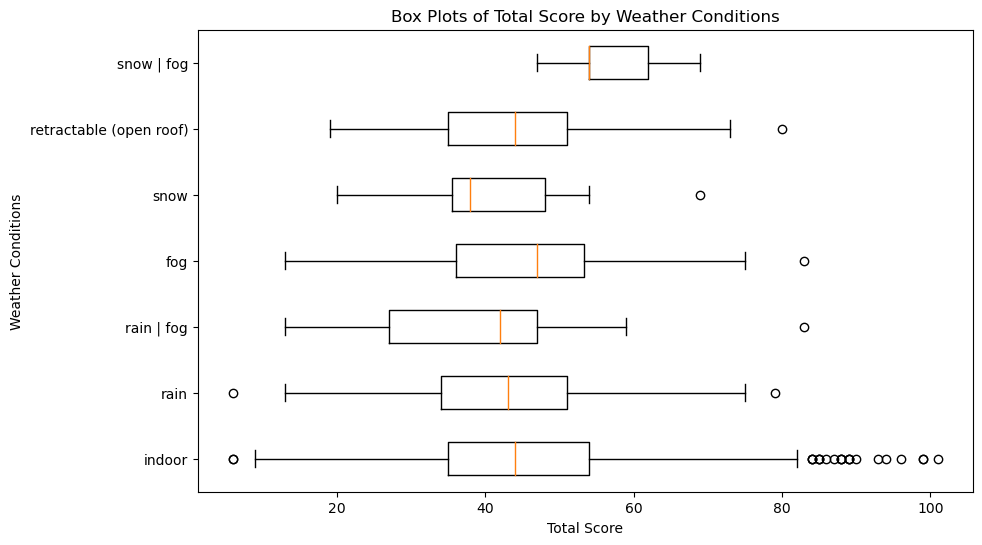

<Figure size 640x480 with 0 Axes>

In [49]:
# Define the specific weather conditions
specific_conditions = ["indoor", "rain", "rain | fog", "fog", "snow", "retractable (open roof)", "snow | fog"]

# Create a list to store boxplot data and labels
boxplot_data = []
category_labels = []

# Filter the data for each specific condition and store the "total_score"
for condition in specific_conditions:
    condition_data = weather_details[weather_details['weather_detail'] == condition]['total_score']
    boxplot_data.append(condition_data)
    category_labels.append(condition)

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=category_labels, vert=False)

# Set labels and title
plt.xlabel('Total Score')
plt.ylabel('Weather Conditions')
plt.title('Box Plots of Total Score by Weather Conditions')

# Show the plot
plt.show()
plt.savefig('images/TSWC.png')


In [60]:
# Perform the ANOVA test on 'total_score' by 'weather_detail' categories
anova_result = st.f_oneway(
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "indoor"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "rain"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "rain | fog"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "fog"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "snow"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "retractable (open roof)"],
    final_scores_data['total_score'][final_scores_data['weather_detail'] == "snow | fog"]
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 1.9539575467923553
ANOVA p-value: 0.06882387103585054
The differences are not statistically significant (fail to reject the null hypothesis).


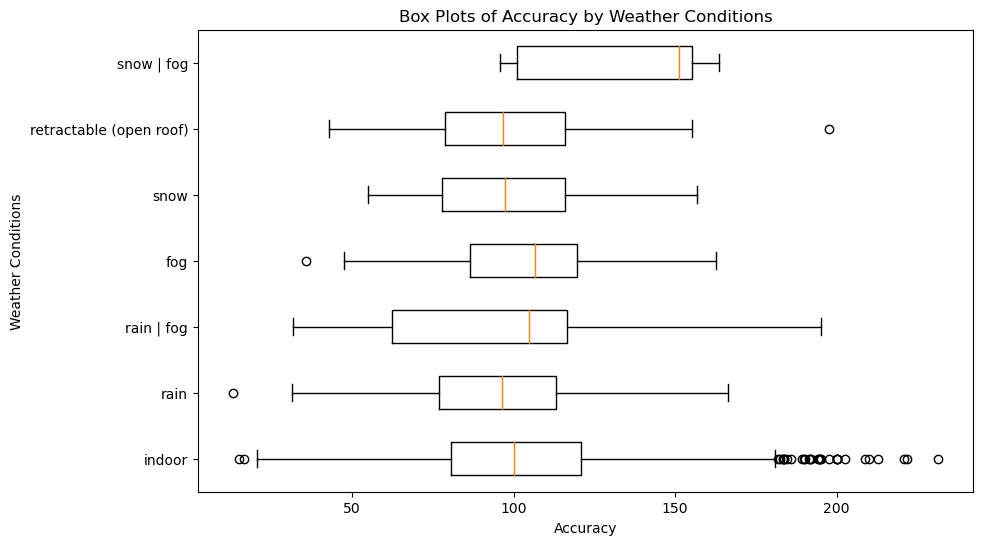

<Figure size 640x480 with 0 Axes>

In [50]:
# Define the specific weather conditions
specific_conditions = ["indoor", "rain", "rain | fog", "fog", "snow", "retractable (open roof)", "snow | fog"]

# Create a list to store boxplot data and labels
boxplot_data = []
category_labels = []

# Filter the data for each specific condition and store the "total_score"
for condition in specific_conditions:
    condition_data = weather_details[weather_details['weather_detail'] == condition]['accuracy']
    boxplot_data.append(condition_data)
    category_labels.append(condition)

# Create a box plot
plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=category_labels, vert=False)

# Set labels and title
plt.xlabel('Accuracy')
plt.ylabel('Weather Conditions')
plt.title('Box Plots of Accuracy by Weather Conditions')

# Show the plot
plt.show()
plt.savefig('images/ACCWC.png')


In [62]:
# Perform the ANOVA test on 'accuracy' by 'weather_detail' categories
anova_result = st.f_oneway(
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "indoor"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "rain"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "rain | fog"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "fog"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "snow"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "retractable (open roof)"],
    final_scores_data['accuracy'][final_scores_data['weather_detail'] == "snow | fog"]
)

# Print the ANOVA results
print("ANOVA F-statistic:", anova_result.statistic)
print("ANOVA p-value:", anova_result.pvalue)

# Check for significance
if anova_result.pvalue < 0.05:
    print("The differences are statistically significant (reject the null hypothesis).")
else:
    print("The differences are not statistically significant (fail to reject the null hypothesis).")


ANOVA F-statistic: 1.6750565276914358
ANOVA p-value: 0.12300431201161476
The differences are not statistically significant (fail to reject the null hypothesis).
